In [15]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [16]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/emd_masksift_CA1_config_2500.yml')

In [17]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [18]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [19]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [20]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [21]:
from structure_index import compute_structure_index, draw_graph

In [22]:
# Rotation and Translation of dataset to align it to another dataset (template) based on a feature
# Arguments:
# data = Dataset of size N to be aligned
# feature = an array of size N representing alignment feature
# template_data = Dataset to which (data) will be aligned
# template_feature = an array representing alignment feature of the template data
def align_point_cloud(data, feature,
                      template_data,
                      template_feature,
                      n_bins=15,
                      n_neighbors=15,
                      dims=None,
                      distance_metric='euclidean',
                      discrete_label=False,
                      num_shuffles=10,
                      verbose=False):
    params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

    # Get bins from the data
    SI, binLabel, overlapMat, sSI = compute_structure_index(data, np.array(feature), **params)
    SI_temp, binLabel_temp, overlapMat_temp, sSI_temp = compute_structure_index(template_data, np.array(template_feature), **params)

    # Get centroids of bins (p and p'); these are the points that will be aligned
    p = []
    for i in range(params['n_bins']):
        p.append(np.mean(data[binLabel[0] == i], axis=0))
    p = np.array(p)
    
    p_temp = []
    for i in range(params['n_bins']):
        p_temp.append(np.mean(template_data[binLabel_temp[0] == i], axis=0))
    p_temp = np.array(p_temp)

    # q = p - mean(p)
    # Get deviations of points from their means (q and q'); the Qs are used to get the scatter matrix H
    p_mean = np.mean(p, axis=0)
    p_temp_mean = np.mean(p_temp, axis=0)
    q = p - p_mean
    q_temp = p_temp - p_temp_mean

    # Get Rotation matrix
    H = np.dot(q_temp.T, q)
    U, S, Vh = np.linalg.svd(H, full_matrices=True)
    R = np.dot(U, Vh)
    if np.linalg.det(R) < 0:
        Vh[Vh.shape[0]-1, :] = Vh[Vh.shape[0]-1, :] * (-1)
        R = np.dot(U, Vh)

    T = p_temp_mean - np.dot(p_mean, R)
    new_data = np.dot(data, R) + T
    return new_data

In [27]:
# Revised version of prepare_data_for_umap
def prepare_data_for_umap(imfs, imf_frequencies):
    waveforms = pd.DataFrame()
    all_trials = pd.DataFrame()
    all_FPPs = []

    theta_range = [5, 12]
    angles=np.linspace(-180,180,19)
    frequencies = np.arange(15, 141, 1)
    fs = 2500

    for idx, imf in enumerate(imfs):
        cycle_data = get_cycle_data(imf[:, 5], fs=2500)

        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs / 5
        hi_freq_duration = fs / 12

        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']
        
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

        if all_cycles is None or all_cycles.chain_vect.size == 0:
            continue

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)

        # --- KEY CHANGE HERE ---
        # Instead of storing waveforms, we store the start and end sample indices
        # for each cycle.
        if cycles_inds.size == 0:
            continue
            
        trial = all_cycles.get_metric_dataframe(subset=True)
        trial['start_sample'] = cycles_inds[:, 0]
        trial['end_sample'] = cycles_inds[:, 1]
        # --- END OF KEY CHANGE ---
        
        freqs = imf_frequencies[idx]
        _, _, supra_theta = tg_split(freqs, theta_range)
        supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

        raw_data = sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5, ret_mode='power', normalise=None)
        supraPlot = scipy.stats.zscore(raw_data, axis=1)
        FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
        all_FPPs.append(FPP)

        mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

        all_aligned_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                          cycles=all_cycles.iterate(through='subset'), npoints=100)
        all_aligned_waveforms = pd.DataFrame(all_aligned_waveforms.T)
        waveforms = pd.concat([waveforms, all_aligned_waveforms])

        trial['mode_freqs'] = mode_freqs
        trial['entropy'] = entropies
        
        all_trials = pd.concat([all_trials, trial])

    return waveforms, all_trials, all_FPPs

In [28]:
import os
import pandas as pd
import re
from tqdm import tqdm

def extract_data_for_rat(rat_id):
    base_path = '/Users/amir/Desktop/for Abdel/OS Basic'
    fs = 2500

    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()
    all_phasic_fpps = []
    all_tonic_fpps = []
    theta_imf_store = {}

    rat_path = os.path.join(base_path, str(rat_id))
    if not os.path.isdir(rat_path):
        print(f"Rat folder {rat_id} does not exist.")
        return None, None, None, None, None

    recording_folders = [f for f in os.listdir(rat_path) if os.path.isdir(os.path.join(rat_path, f))]
    if not recording_folders:
        print(f"No recording folders found for Rat {rat_id}.")
        return None, None, None, None, None

    for recording_folder in tqdm(recording_folders, desc="Processing Recordings"):
        print(f"\n>>> Processing recording folder: {recording_folder}")
        recording_path = os.path.join(rat_path, recording_folder)

        match = re.match(r'^Rat-OS-Ephys_(Rat\d+)_SD(\d+)_([\w-]+)_([\d-]+)$', recording_folder)
        if not match:
            print(f"Unexpected folder name format: {recording_folder}. Skipping...")
            continue

        rat_id_part, sd_number, condition, date_part = match.groups()
        rat_id_from_folder = ''.join(filter(str.isdigit, rat_id_part))
        if rat_id_from_folder != str(rat_id):
            print(f"Rat ID mismatch in folder {recording_folder}. Skipping...")
            continue

        trial_folders = [f for f in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, f)) and re.search(r'(?i)post[\\-_]?trial[\\-_]?([2-5])', f)]
        if not trial_folders:
            print(f"No trial folders found in {recording_folder}.")
            continue

        for trial_folder in trial_folders:
            print(f"    -> Processing trial folder: {trial_folder}")
            trial_path = os.path.join(recording_path, trial_folder)

            lfp_file, state_file = None, None
            for file_name in os.listdir(trial_path):
                if 'HPC' in file_name and file_name.endswith('.mat'):
                    lfp_file = os.path.join(trial_path, file_name)
                elif 'state' in file_name.lower() and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)

            if not lfp_file or not state_file:
                print(f"Missing LFP or state file in {trial_path}. Skipping...")
                continue

            trial_number_match = re.search(r'(?i)post[\\-_]?trial[\\-_]?([2-5])', trial_folder)
            trial_number = int(trial_number_match.group(1)) if trial_number_match else -1

            try:
                lfpHPC, hypno, _ = get_data(lfp_file, state_file)
                try:
                    phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
                except ValueError as e:
                    print(f"No REM sleep or data error in {trial_folder}. Skipping. Error: {e}")
                    phasic_interval, tonic_interval = [], []

                if len(phasic_interval) > 0 and len(tonic_interval) > 0:
                    tonic_imfs, tonic_freqs, _ = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                    phasic_imfs, phasic_freqs, _ = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)
                    
                    all_phasic_trials_for_file, all_tonic_trials_for_file = [], []
                    all_phasic_waveforms_for_file, all_tonic_waveforms_for_file = [], []

                    for i, (imf, freq) in enumerate(zip(phasic_imfs, phasic_freqs)):
                        interval_id = f"{recording_folder}_{trial_folder}_phasic_{i}"
                        waveforms, trials, fpps = prepare_data_for_umap([imf], [freq])
                        if not trials.empty:
                            trials['interval_id'] = interval_id
                            theta_imf_store[interval_id] = imf[:, 5]
                            all_phasic_trials_for_file.append(trials)
                            all_phasic_waveforms_for_file.append(waveforms)
                            all_phasic_fpps.extend(fpps)

                    for i, (imf, freq) in enumerate(zip(tonic_imfs, tonic_freqs)):
                        interval_id = f"{recording_folder}_{trial_folder}_tonic_{i}"
                        waveforms, trials, fpps = prepare_data_for_umap([imf], [freq])
                        if not trials.empty:
                            trials['interval_id'] = interval_id
                            theta_imf_store[interval_id] = imf[:, 5]
                            all_tonic_trials_for_file.append(trials)
                            all_tonic_waveforms_for_file.append(waveforms)
                            all_tonic_fpps.extend(fpps)

                    if all_phasic_trials_for_file:
                        phasic_trials = pd.concat(all_phasic_trials_for_file, ignore_index=True)
                        phasic_waveforms = pd.concat(all_phasic_waveforms_for_file, ignore_index=True)
                        
                        # --- THIS IS THE FIX ---
                        # Using direct assignment which is robust and works.
                        phasic_trials['rat_id'] = rat_id
                        phasic_trials['condition'] = condition
                        phasic_trials['trial'] = trial_number
                        phasic_trials['cycle_type'] = 'phasic'
                        phasic_trials['SD'] = sd_number
                        phasic_trials['date'] = date_part
                        # -----------------------
                        
                        all_combined_waveforms = pd.concat([all_combined_waveforms, phasic_waveforms], ignore_index=True)
                        all_combined_trials = pd.concat([all_combined_trials, phasic_trials], ignore_index=True)

                    if all_tonic_trials_for_file:
                        tonic_trials = pd.concat(all_tonic_trials_for_file, ignore_index=True)
                        tonic_waveforms = pd.concat(all_tonic_waveforms_for_file, ignore_index=True)
                        
                        # --- THIS IS THE FIX ---
                        # Using direct assignment which is robust and works.
                        tonic_trials['rat_id'] = rat_id
                        tonic_trials['condition'] = condition
                        tonic_trials['trial'] = trial_number
                        tonic_trials['cycle_type'] = 'tonic'
                        tonic_trials['SD'] = sd_number
                        tonic_trials['date'] = date_part
                        # -----------------------

                        all_combined_waveforms = pd.concat([all_combined_waveforms, tonic_waveforms], ignore_index=True)
                        all_combined_trials = pd.concat([all_combined_trials, tonic_trials], ignore_index=True)

            except Exception as e:
                print(f"An unexpected error occurred in {trial_path}: {e}")
                import traceback
                traceback.print_exc()

    if all_combined_trials.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None, None, None, None

    return all_combined_waveforms, all_combined_trials, all_phasic_fpps, all_tonic_fpps, theta_imf_store

In [43]:
def extract_component_patches(trials_df_with_components, theta_imf_store, min_cycles_in_patch=2):
    """
    Finds consecutive sequences (patches) of theta cycles, and extracts the
    single continuous waveform for each patch.
    """
    all_patches = []
    
    # Group by each contiguous REM episode to find consecutive cycles correctly
    grouped_by_interval = trials_df_with_components.groupby('interval_id')

    for interval_id, interval_df in grouped_by_interval:
        if len(interval_df) < min_cycles_in_patch:
            continue

        # Get the source IMF for this entire interval
        source_imf = theta_imf_store.get(interval_id)
        if source_imf is None:
            continue # Skip if we can't find the source IMF for some reason
            
        cycles = interval_df.to_dict('records')
        current_patch = []
        for cycle in cycles:
            if not current_patch or cycle['tSC_component'] != current_patch[-1]['tSC_component']:
                # End the old patch
                if len(current_patch) >= min_cycles_in_patch:
                    first_cycle = current_patch[0]
                    last_cycle = current_patch[-1]
                    
                    # Perform the single, continuous slice
                    start_idx = first_cycle['start_sample']
                    end_idx = last_cycle['end_sample']
                    continuous_waveform = source_imf[start_idx : end_idx + 1]
                    
                    patch_data = {
                        'component': first_cycle['tSC_component'],
                        'cycle_type': first_cycle['cycle_type'],
                        'mode_frequency': first_cycle.get('mode_freqs', None),
                        'num_cycles': len(current_patch),
                        'waveform': continuous_waveform, # NOTE: singular 'waveform'
                        'cycle_durations': [(c['end_sample'] - c['start_sample']) for c in current_patch]
                    }
                    all_patches.append(patch_data)
                
                # Start a new patch
                current_patch = [cycle]
            else:
                current_patch.append(cycle)

        # After the loop, check the last patch
        if len(current_patch) >= min_cycles_in_patch:
            first_cycle, last_cycle = current_patch[0], current_patch[-1]
            start_idx, end_idx = first_cycle['start_sample'], last_cycle['end_sample']
            continuous_waveform = source_imf[start_idx : end_idx + 1]
            all_patches.append({
                'component': first_cycle['tSC_component'], 'cycle_type': first_cycle['cycle_type'],
                'num_cycles': len(current_patch), 'waveform': continuous_waveform,
                'cycle_durations': [(c['end_sample'] - c['start_sample']) for c in current_patch]
            })
            
    return all_patches

def plot_example_patches(patches, n_examples=5, n_components=5):
    """ Plots the continuous waveform for each patch. """
    if not patches:
        print("No patches found to plot.")
        return

    colors = plt.cm.viridis(np.linspace(0, 1, n_components))
    fig, axes = plt.subplots(n_examples, 1, figsize=(15, 3 * n_examples), sharey=True)
    fig.suptitle('Example Theta IMF Patches by Component', fontsize=16)

    selected_indices = np.random.choice(len(patches), min(n_examples, len(patches)), replace=False)
    axes = np.atleast_1d(axes)

    for i, patch_idx in enumerate(selected_indices):
        patch = patches[patch_idx]
        ax = axes[i]
        
        # The waveform is already continuous!
        full_waveform = patch['waveform']
        time_vector = np.arange(len(full_waveform)) / 2500.0

        component = patch['component']
        ax.plot(time_vector, full_waveform, color=colors[component], lw=1.5)
        
        # Draw vertical lines based on stored cycle durations
        current_time_samples = 0
        for duration in patch['cycle_durations'][:-1]: # Don't draw line at the very end
            current_time_samples += duration
            ax.axvline(current_time_samples / 2500.0, color='gray', linestyle='--', alpha=0.7, lw=1)

        title = f"Patch from {patch['cycle_type'].capitalize()} REM | Component {component + 1} | {patch['num_cycles']} consecutive cycles"
        ax.set_title(title)
        ax.set_ylabel("Amplitude (uV)")

    axes[-1].set_xlabel("Time within patch (s)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [30]:
rat_id = '11'
waveforms_df, trials_df, all_phasic_FPPs, all_tonic_FPPs, theta_imf_store = extract_data_for_rat(rat_id)

Processing Recordings:   0%|          | 0/4 [00:00<?, ?it/s]


>>> Processing recording folder: Rat-OS-Ephys_Rat11_SD1_CON_29-10-2018
    -> Processing trial folder: 2018-10-29_12-41-45_Post_Trial2
There was 0 in the dataset
Number of detected Tonic intrevals:7
Number of detected Tonic intrevals after threshold:7
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton f

Processing Recordings:  25%|██▌       | 1/4 [02:14<06:42, 134.25s/it]


>>> Processing recording folder: Rat-OS-Ephys_Rat11_SD3_HC_02-11-2018
    -> Processing trial folder: 2018-11-02_14-17-36_Post_Trial5
Number of detected Tonic intrevals:30
Number of detected Tonic intrevals after threshold:30
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking C

Processing Recordings:  50%|█████     | 2/4 [04:54<04:59, 149.65s/it]


>>> Processing recording folder: Rat-OS-Ephys_Rat11_SD2_OD_32-10-2018
    -> Processing trial folder: 2018-10-31_12-06-31_Post_Trial2
There was 0 in the dataset
Number of detected Tonic intrevals:10
Number of detected Tonic intrevals after threshold:10
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

Processing Recordings:  75%|███████▌  | 3/4 [07:13<02:24, 144.72s/it]


>>> Processing recording folder: Rat-OS-Ephys_Rat11_SD4_OR_03-11-2018
    -> Processing trial folder: 2018-11-05_14-15-28_Post_Trial5
There was 0 in the dataset
Number of detected Tonic intrevals:54
Number of detected Tonic intrevals after threshold:54
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

Processing Recordings: 100%|██████████| 4/4 [09:56<00:00, 149.10s/it]


In [31]:
phasic_fpps = np.empty(1, dtype=object)
phasic_fpps[0] = all_phasic_FPPs
print(phasic_fpps.shape)  # (1,)

tonic_fpps = np.empty(1, dtype=object)
tonic_fpps[0] = all_tonic_FPPs
print(tonic_fpps.shape)  # (1,)

(1,)
(1,)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

# --- 1. Define Constants & Load Your Data ---
# These parameters must match what you used in your data generation pipeline
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

# --- UNCOMMENT YOUR LOADING CODE HERE ---
# save_folder = "Os_Basic_Dataset_FPPs"
# phasic_filename = os.path.join(save_folder, "Os_Basic_Dataset_arrays_of_phasic_fpps.npy")
# tonic_filename = os.path.join(save_folder, "Os_Basic_Dataset_arrays_of_tonic_fpps.npy")

# print("Loading the saved arrays...")
# phasic_fpps = np.load(phasic_filename, allow_pickle=True)
# tonic_fpps = np.load(tonic_filename, allow_pickle=True)
# print("Successfully loaded arrays.")
# ----------------------------------------

# --- 2. Data Flattening Function (Handles the 3D Array Structure) ---
def flatten_fpp_data_final(fpps_by_rat):
    """
    Correctly flattens the Array[List[3D Array]] structure into a single
    flat list of 2D FPP arrays.
    """
    all_2d_fpps = []
    # Level 1: Iterate over each rat
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list):
            continue
        # Level 2: Iterate over each interval's 3D array
        for interval_3d_array in rat_data_list:
            # Check if it's a 3D numpy array with at least one cycle
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] > 0:
                # Level 3: Iterate through each cycle (the first dimension)
                # and append the 2D FPP to our master list.
                for i in range(interval_3d_array.shape[0]):
                    all_2d_fpps.append(interval_3d_array[i, :, :])
    return all_2d_fpps

print("--- Flattening Data ---")
flattened_phasic = flatten_fpp_data_final(phasic_fpps)
flattened_tonic = flatten_fpp_data_final(tonic_fpps)

print(f"Total number of Phasic FPPs found: {len(flattened_phasic)}")
print(f"Total number of Tonic FPPs found: {len(flattened_tonic)}")
print("-" * 20)

--- Flattening Data ---
Total number of Phasic FPPs found: 2899
Total number of Tonic FPPs found: 58272
--------------------


In [33]:
# --- 3. Data Processing Function ---
def process_fpps_for_plotting(fpp_list, description=""):
    """
    Takes a flat list of 2D FPPs, filters them for consistent shapes,
    and computes the necessary averages for plotting.
    Returns a dictionary with processed data, or None if no valid data.
    """
    if not fpp_list:
        print(f"No FPPs to process for {description}.")
        return None

    # Filter for arrays with the most common, valid shape to avoid errors
    shape_counts = Counter(arr.shape for arr in fpp_list if isinstance(arr, np.ndarray))
    if not shape_counts:
        print(f"No valid NumPy arrays found for {description}.")
        return None
        
    most_common_shape = shape_counts.most_common(1)[0][0]
    valid_fpps = [arr for arr in fpp_list if hasattr(arr, 'shape') and arr.shape == most_common_shape]
    
    print(f"Processing '{description}':")
    print(f"  - Found {len(valid_fpps)} valid FPPs with shape {most_common_shape}.")
    if len(valid_fpps) < len(fpp_list):
        print(f"  - Ignored {len(fpp_list) - len(valid_fpps)} entries with inconsistent shapes or types.")
    
    if not valid_fpps:
        return None

    # Stack the valid FPPs into a single 3D array
    stacked_fpps = np.stack(valid_fpps, axis=0)

    # --- Calculations for Plots ---
    # 1. For the averaged spectrogram
    avg_fpp = np.mean(stacked_fpps, axis=0)

    # 2. For the spectral signature
    all_signatures = np.mean(stacked_fpps, axis=2) # Average over phase angles
    mean_signature = np.mean(all_signatures, axis=0)
    std_signature = np.std(all_signatures, axis=0)

    # Return all processed data in a dictionary
    return {
        'avg_fpp': avg_fpp,
        'mean_signature': mean_signature,
        'std_signature': std_signature,
        'n_valid': len(valid_fpps),
        'shape': most_common_shape
    }

print("\n--- Processing Flattened Data ---")
phasic_processed = process_fpps_for_plotting(flattened_phasic, "Phasic REM")
tonic_processed = process_fpps_for_plotting(flattened_tonic, "Tonic REM")
print("-" * 20)



--- Processing Flattened Data ---
Processing 'Phasic REM':
  - Found 2899 valid FPPs with shape (126, 19).
Processing 'Tonic REM':
  - Found 58272 valid FPPs with shape (126, 19).
--------------------


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
from collections import defaultdict, Counter
from sklearn.decomposition import PCA, FastICA

# New imports for interactive plotting
import plotly.graph_objects as go
import networkx as nx

# ===================================================================
# ---              UNCHANGED FUNCTIONS (Parts 1-3)                ---
# ===================================================================
def extract_sss_by_episode(fpps_by_rat):
    episodes_sss_list = []
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list): continue
        for interval_3d_array in rat_data_list:
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] > 1:
                current_episode_sss = []
                for i in range(interval_3d_array.shape[0]):
                    fpp_2d = interval_3d_array[i, :, :]
                    fpp_abs = np.abs(fpp_2d)
                    norm_sum = np.sum(fpp_abs)
                    normalized_fpp = fpp_abs / norm_sum if norm_sum > 1e-9 else fpp_abs
                    signature_1d = np.sum(normalized_fpp, axis=1)
                    signature_smoothed = np.convolve(signature_1d, np.ones(5)/5, mode='same')
                    sig_min, sig_max = np.min(signature_smoothed), np.max(signature_smoothed)
                    if (sig_max - sig_min) > 1e-9:
                        signature_final = (signature_smoothed - sig_min) / (sig_max - sig_min)
                    else:
                        signature_final = np.zeros_like(signature_smoothed)
                    current_episode_sss.append(signature_final)
                episodes_sss_list.append(np.array(current_episode_sss))
    return episodes_sss_list

def train_global_ica_model(all_sss_data, n_components):
    print(f"Training global PCA/ICA model with {n_components} components...")
    if all_sss_data.shape[0] < n_components: return None, None
    pca = PCA(n_components=n_components, random_state=42)
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000, tol=0.001)
    pca_result = pca.fit_transform(all_sss_data)
    ica.fit(pca_result)
    print("Model training complete.")
    return pca, ica

def plot_ica_components(pca_model, ica_model, frequencies, title_suffix, save_path):
    tSCs_weights_original = np.dot(ica_model.components_, pca_model.components_)
    n_components = ica_model.components_.shape[0]
    colors = plt.cm.viridis(np.linspace(0, 1, n_components))
    plt.figure(figsize=(12, 7))
    for i in range(n_components):
        weights = tSCs_weights_original[i, :]
        peak_idx = np.argmax(np.abs(weights))
        peak_freq = frequencies[peak_idx]
        plt.plot(frequencies, weights, color=colors[i], label=f'tSC {i+1} (Peak: {peak_freq:.1f} Hz)')
        plt.scatter(peak_freq, weights[peak_idx], color=colors[i], edgecolor='k', s=50, zorder=5)
    plt.xlabel('Frequency (Hz)', fontsize=14); plt.ylabel('Weight', fontsize=14); plt.title(f'Theta Spectral Components (tSCs) - {title_suffix}', fontsize=16)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig(save_path, format='svg'); plt.show()

def get_component_sequences(sss_by_episode, pca_model, ica_model):
    all_sequences = []
    for episode_sss in sss_by_episode:
        episode_pca = pca_model.transform(episode_sss)
        episode_tSCs = ica_model.transform(episode_pca)
        component_sequence = np.argmax(np.abs(episode_tSCs), axis=1)
        all_sequences.append(component_sequence)
    return all_sequences

def calculate_transition_matrix(component_sequences):
    """
    Calculates a transition count matrix from a list of component sequences.
    """
    if not any(len(seq) > 0 for seq in component_sequences):
        return np.array([])
        
    max_id = 0
    for seq in component_sequences:
        if len(seq) > 0:
            max_id = max(max_id, np.max(seq))
    n_comp = max_id + 1
    
    transition_matrix = np.zeros((n_comp, n_comp), dtype=int)

    for seq in component_sequences:
        for i in range(len(seq) - 1):
            # --- CORRECTED LOGIC ---
            from_comp = seq[i]
            to_comp = seq[i+1]
            # -----------------------
            transition_matrix[from_comp, to_comp] += 1
            
    return transition_matrix


# def plot_transition_matrix(transition_counts, title, save_path):
#     if transition_counts.size == 0: return
#     row_sums = transition_counts.sum(axis=1, keepdims=True)
#     with np.errstate(divide='ignore', invalid='ignore'): prob_matrix = np.nan_to_num(transition_counts / row_sums)
#     prob_matrix_viz = prob_matrix.copy()
#     np.fill_diagonal(prob_matrix_viz, 0)
#     plt.figure(figsize=(10, 8)); ax = sns.heatmap(prob_matrix_viz, annot=prob_matrix, fmt=".2f", cmap="hot", linewidths=.5, cbar_kws={'label': 'Transition Probability'})
#     labels = [f'tSC {i+1}' for i in range(prob_matrix.shape[0])]
#     ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels, rotation=0)
#     ax.set_xlabel("To Component", fontsize=14); ax.set_ylabel("From Component", fontsize=14); ax.set_title(title, fontsize=16)
#     plt.tight_layout(); plt.savefig(save_path, format='svg'); plt.show()

def plot_transition_matrix(transition_counts, title, save_path):
    if transition_counts.size == 0:
        return

    row_sums = transition_counts.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_matrix = np.nan_to_num(transition_counts / row_sums)

    prob_matrix_viz = prob_matrix.copy()
    np.fill_diagonal(prob_matrix_viz, 0)

    # ------- changed block starts here -------
    cmap = plt.cm.get_cmap('bwr')          # blue-white-red
    ax = sns.heatmap(
        prob_matrix_viz,
        annot=prob_matrix,
        fmt=".2f",
        cmap=cmap,
        vmin=0, vmax=1,                    # full probability range
        center=0.5,                        # make 0.5 the neutral (white) midpoint
        linewidths=.5,
        cbar_kws={
            'label': 'Transition Probability',
            'ticks': [0, 0.25, 0.5, 0.75, 1]
        }
    )
    # ------- changed block ends here -------

    labels = [f'tSC {i+1}' for i in range(prob_matrix.shape[0])]
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_xlabel("To Component", fontsize=14)
    ax.set_ylabel("From Component", fontsize=14)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, format='svg')
    plt.show()

def plot_interactive_transition_graph(prob_matrix, node_counts, title, prob_threshold=0.05):
    n_components = prob_matrix.shape[0]
    G = nx.DiGraph()

    min_node_size, max_node_size = 15, 50
    total_cycles = np.sum(node_counts)
    if total_cycles == 0: total_cycles = 1
    node_sizes = min_node_size + (node_counts / total_cycles) * (max_node_size - min_node_size)
    colors = plt.cm.viridis(np.linspace(0, 1, n_components))

    for i in range(n_components):
        G.add_node(i, size=node_sizes[i], label=f"tSC {i+1}", color=mcolors.to_hex(colors[i]), hover_text=f"tSC {i+1}<br>Cycle Count: {node_counts[i]}")

    for i in range(n_components):
        for j in range(n_components):
            prob = prob_matrix[i, j]
            if prob > prob_threshold and i != j:
                G.add_edge(i, j, weight=prob, label=f"{prob:.2f}")

    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]; x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None]); edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
    node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x); node_y.append(y); node_text.append(G.nodes[node]['hover_text'])
        node_size.append(G.nodes[node]['size']); node_color.append(G.nodes[node]['color'])

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=[G.nodes[node]['label'] for node in G.nodes()], textposition="top center",
        hoverinfo='text', hovertext=node_text, marker=dict(showscale=False, colorscale='Viridis', reversescale=True, color=node_color, size=node_size, line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title=f'<br><b>{title}</b>', titlefont_size=16, showlegend=False, hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40), annotations=[dict(text=f"Edge arrows show transition probability > {prob_threshold}", showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002)],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False), yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]; x1, y1 = pos[edge[1]]
        fig.add_annotation(ax=x0, ay=y0, axref='x', ayref='y', x=x0*0.2 + x1*0.8, y=y0*0.2 + y1*0.8, xref='x', yref='y', showarrow=True, arrowhead=2, arrowsize=2, arrowwidth=1)
        fig.add_annotation(x=(x0+x1)/2, y=(y0+y1)/2, text=edge[2]['label'], showarrow=False, font=dict(size=10, color="black"))
    return fig


--- Step 1: Processing data ---

--- Step 2: Training global model ---
Training global PCA/ICA model with 5 components...
Model training complete.

--- Step 3: Visualizing global components ---


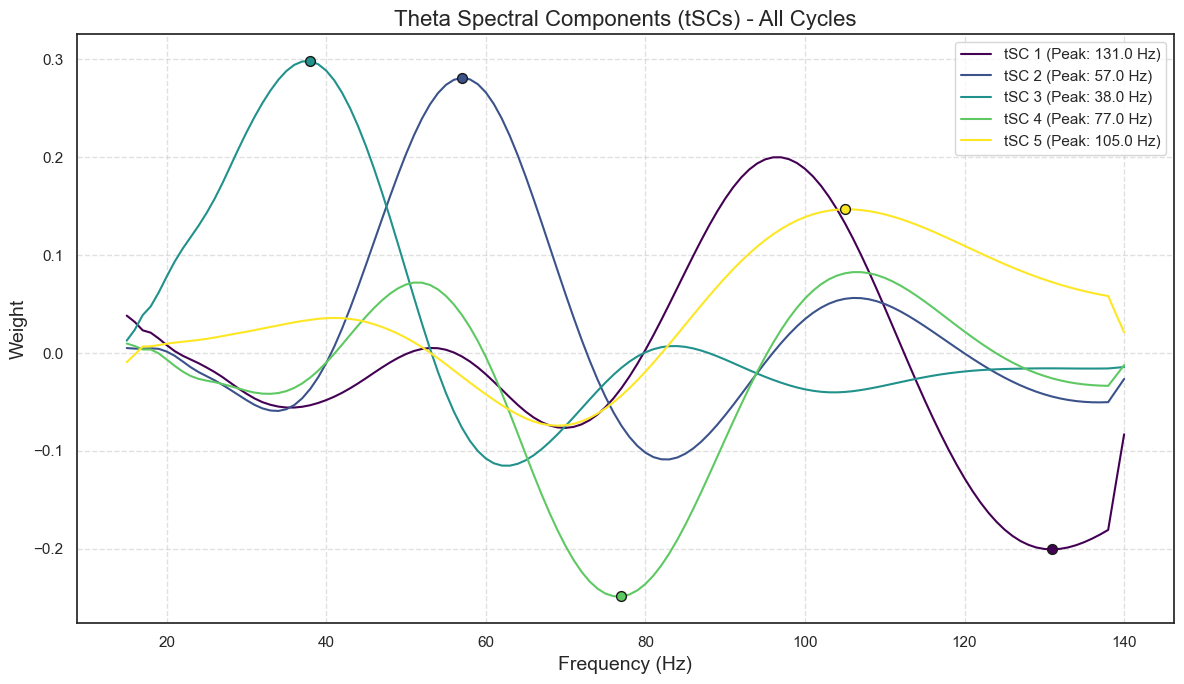


--- Step 4: Assigning components and calculating transitions ---

Component Composition:
  Component 1: 624 phasic cycles, 10555 tonic cycles
  Component 2: 641 phasic cycles, 12516 tonic cycles
  Component 3: 519 phasic cycles, 11373 tonic cycles
  Component 4: 587 phasic cycles, 12418 tonic cycles
  Component 5: 528 phasic cycles, 11409 tonic cycles


In [35]:
frequencies = np.arange(15, 141, 1)

print("--- Step 1: Processing data ---")
phasic_sss_by_episode = extract_sss_by_episode(phasic_fpps)
tonic_sss_by_episode = extract_sss_by_episode(tonic_fpps)
combined_all_sss = np.concatenate(phasic_sss_by_episode + tonic_sss_by_episode, axis=0)

print("\n--- Step 2: Training global model ---")
n_components_pca = 5
pca_model, ica_model = train_global_ica_model(combined_all_sss, n_components_pca)
if ica_model is None: exit()

print("\n--- Step 3: Visualizing global components ---")
plot_ica_components(pca_model, ica_model, frequencies, "All Cycles", "spectral_components_combined.svg")

print("\n--- Step 4: Assigning components and calculating transitions ---")
phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
tonic_sequences = get_component_sequences(tonic_sss_by_episode, pca_model, ica_model)

print("\nComponent Composition:")
all_phasic_comps = np.concatenate(phasic_sequences) if phasic_sequences else np.array([])
all_tonic_comps = np.concatenate(tonic_sequences) if tonic_sequences else np.array([])
phasic_counts_counter = Counter(all_phasic_comps); tonic_counts_counter = Counter(all_tonic_comps)
phasic_node_counts = np.array([phasic_counts_counter.get(i, 0) for i in range(n_components_pca)])
tonic_node_counts = np.array([tonic_counts_counter.get(i, 0) for i in range(n_components_pca)])
for i in range(n_components_pca): print(f"  Component {i+1}: {phasic_node_counts[i]} phasic cycles, {tonic_node_counts[i]} tonic cycles")

In [36]:
all_cycles_count = 0
for i in range(n_components_pca):
    all_cycles_count += phasic_node_counts[i] + tonic_node_counts[i]
print(f"\nTotal cycles processed: {all_cycles_count} (Phasic: {np.sum(phasic_node_counts)}, Tonic: {np.sum(tonic_node_counts)})")
print(f"Precentage of Phasic Cycles: {np.sum(phasic_node_counts) / all_cycles_count * 100 if all_cycles_count > 0 else 0}")
print(f"Precentage of Tonic Cycles: {np.sum(tonic_node_counts) / all_cycles_count * 100 if all_cycles_count > 0 else 0}")



Total cycles processed: 61170 (Phasic: 2899, Tonic: 58271)
Precentage of Phasic Cycles: 4.739251266960928
Precentage of Tonic Cycles: 95.26074873303907


In [37]:
def extract_sss_by_episode(fpps_by_rat):
    episodes_sss_list = []
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list):
            continue
        for interval_3d_array in rat_data_list:
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] >= 1:
                current_episode_sss = []
                for i in range(interval_3d_array.shape[0]):
                    fpp_2d = interval_3d_array[i, :, :]
                    fpp_abs = np.abs(fpp_2d)
                    norm_sum = np.sum(fpp_abs)
                    normalized_fpp = fpp_abs / norm_sum if norm_sum > 1e-9 else fpp_abs
                    signature_1d = np.sum(normalized_fpp, axis=1)
                    signature_smoothed = np.convolve(signature_1d, np.ones(5)/5, mode='same')
                    sig_min, sig_max = np.min(signature_smoothed), np.max(signature_smoothed)
                    if (sig_max - sig_min) > 1e-9:
                        signature_final = (signature_smoothed - sig_min) / (sig_max - sig_min)
                    else:
                        signature_final = np.zeros_like(signature_smoothed)
                    current_episode_sss.append(signature_final)
                episodes_sss_list.append(np.array(current_episode_sss))
    return episodes_sss_list

In [38]:
# Re-extract (now including 1-cycle episodes)
phasic_sss_by_episode = extract_sss_by_episode(phasic_fpps)
tonic_sss_by_episode  = extract_sss_by_episode(tonic_fpps)

# Option A: reuse existing PCA/ICA
phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
tonic_sequences  = get_component_sequences(tonic_sss_by_episode,  pca_model, ica_model)

# Option B (optional): retrain with all cycles included
# combined_all_sss = np.concatenate(phasic_sss_by_episode + tonic_sss_by_episode, axis=0)
# pca_model, ica_model = train_global_ica_model(combined_all_sss, n_components_pca)
# phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
# tonic_sequences  = get_component_sequences(tonic_sss_by_episode,  pca_model, ica_model)

In [39]:
phasic_labels = np.concatenate(phasic_sequences) if phasic_sequences else np.array([], dtype=int)
tonic_labels  = np.concatenate(tonic_sequences)  if tonic_sequences  else np.array([], dtype=int)

is_phasic = trials_df['cycle_type'].str.lower().eq('phasic')
is_tonic  = trials_df['cycle_type'].str.lower().eq('tonic')

n_phasic_rows = int(is_phasic.sum())
n_tonic_rows  = int(is_tonic.sum())

print(f"phasic rows vs labels: {n_phasic_rows} vs {len(phasic_labels)}")
print(f"tonic  rows vs labels: {n_tonic_rows}  vs {len(tonic_labels)}")

# If they still mismatch, stop and inspect
assert len(phasic_labels) == n_phasic_rows, "Phasic count mismatch"
assert len(tonic_labels)  == n_tonic_rows,  "Tonic count mismatch"

trials_df = trials_df.copy()
trials_df['tSC_component'] = -1
trials_df.loc[is_phasic, 'tSC_component'] = phasic_labels
trials_df.loc[is_tonic,  'tSC_component'] = tonic_labels

trials_df['tSC_component_1based'] = trials_df['tSC_component'] + 1

phasic rows vs labels: 2899 vs 2899
tonic  rows vs labels: 58272  vs 58272


In [42]:
trials_df.keys()

Index(['index', 'is_good', 'duration_samples', 'peak2trough', 'asc2desc',
       'max_amp', 'trough_values', 'peak_values', 'mean_if', 'max_if',
       'range_if', 'trough_position', 'peak_position', 'chain_ind',
       'start_sample', 'end_sample', 'mode_freqs', 'entropy', 'interval_id',
       'rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date',
       'tSC_component', 'tSC_component_1based'],
      dtype='object')


--- Step 3: Extracting patches of consecutive cycles ---

Found a total of 11107 patches.

Summary of patches found:
cycle_type  phasic  tonic
component                
1              114   1930
2              119   2354
3               72   2034
4               96   2297
5               80   2011

Distribution of patch lengths (number of cycles):
count    11107.000000
mean         2.358333
std          0.737696
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: num_cycles, dtype: float64

--- Step 4: Plotting example patches ---


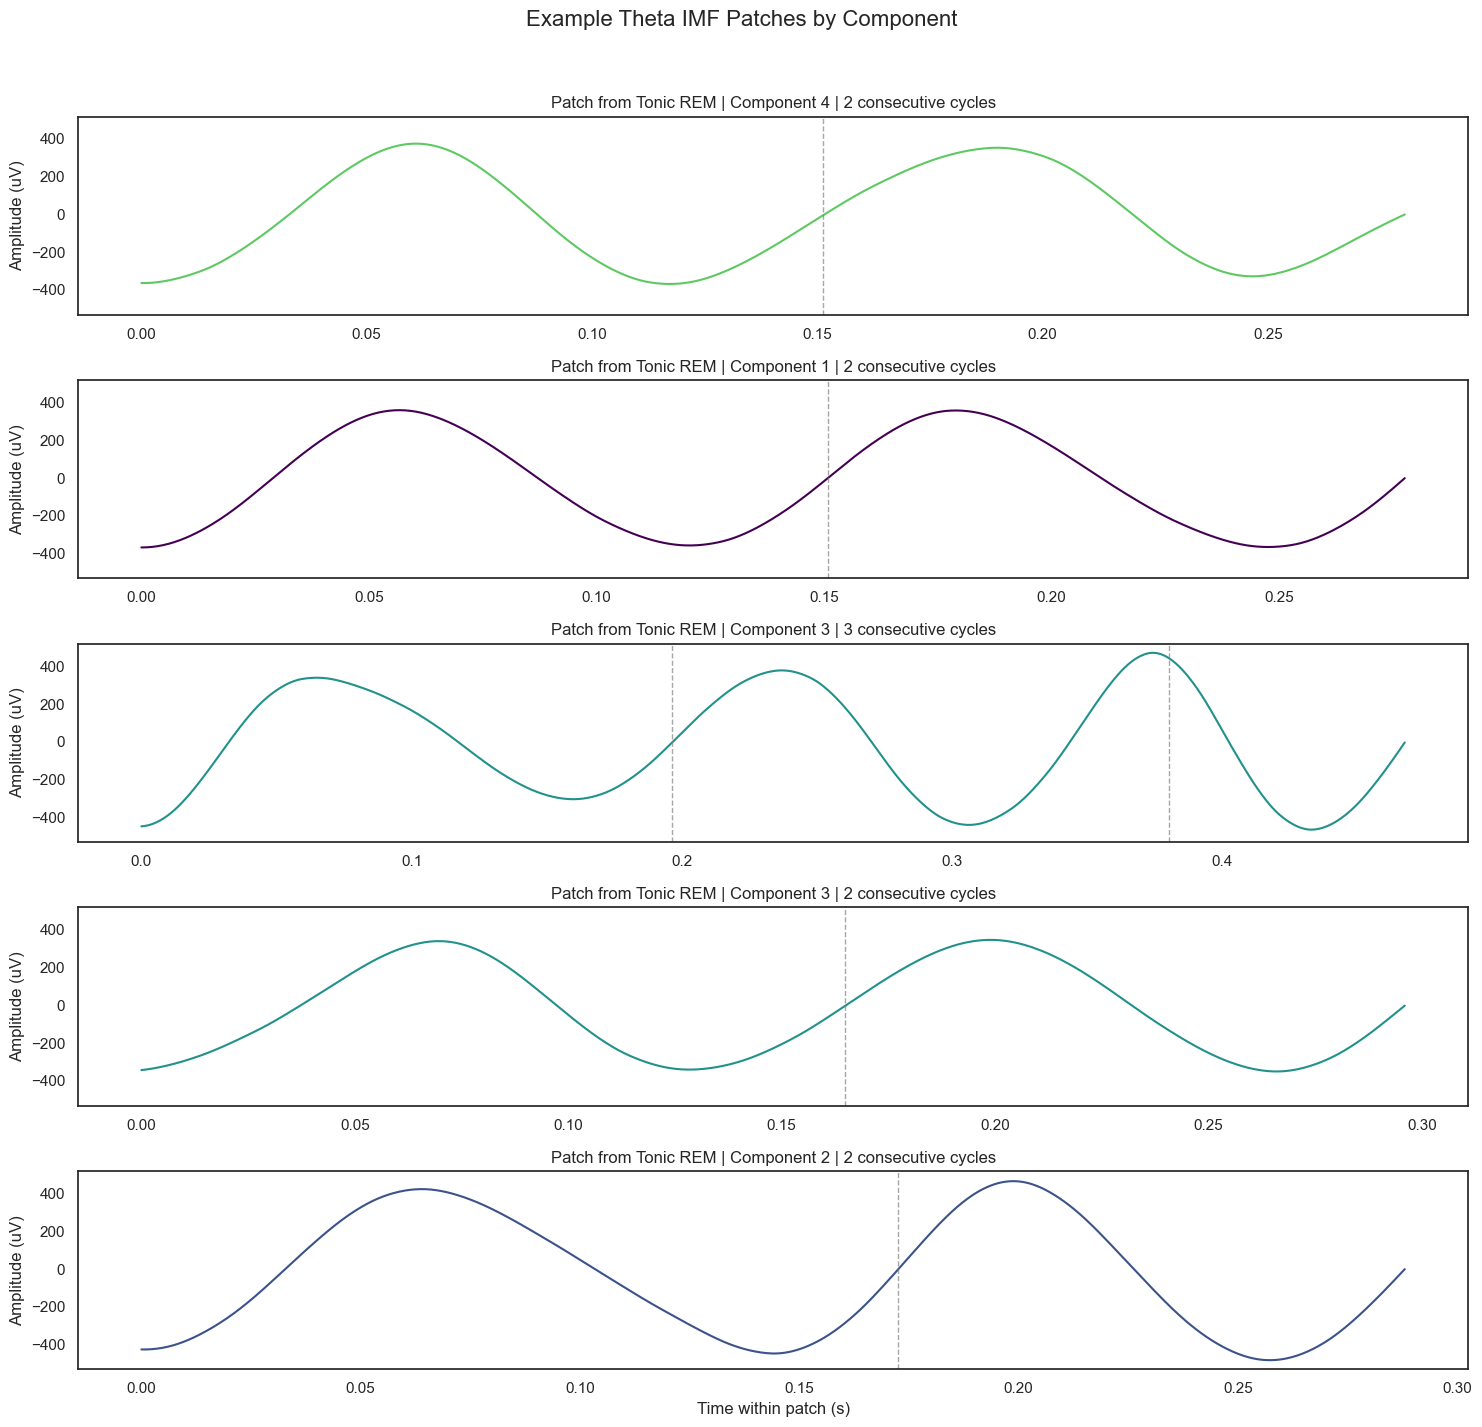

In [44]:
print("\n--- Step 3: Extracting patches of consecutive cycles ---")
if 'tSC_component' in trials_df.columns and not trials_df[trials_df['tSC_component'] != -1].empty:
    valid_cycles_df = trials_df[trials_df['tSC_component'] != -1].copy()
    
    # Pass the new theta_imf_store dictionary
    component_patches = extract_component_patches(valid_cycles_df, theta_imf_store, min_cycles_in_patch=2)

    print(f"\nFound a total of {len(component_patches)} patches.")

    # Summarize the findings
    if component_patches:
        patch_summary = pd.DataFrame(component_patches)
        print("\nSummary of patches found:")
        # Add 1 to component for easier reading (1-5 instead of 0-4)
        patch_summary['component'] = patch_summary['component'] + 1 
        summary_table = pd.crosstab(patch_summary['component'], patch_summary['cycle_type'])
        print(summary_table)

        print("\nDistribution of patch lengths (number of cycles):")
        print(patch_summary['num_cycles'].describe())
        
        print("\n--- Step 4: Plotting example patches ---")
        plot_example_patches(component_patches, n_examples=5, n_components=5)
    else:
        print("\nNo consecutive patches of 2 or more cycles were found.")

else:
    print("Could not find 'tSC_component' column or no components were assigned. Please run the PCA/ICA analysis first.")

In [45]:
# Assuming 'component_patches' is your list of dictionaries
save_path = 'cycles_with_components/component_patches.npy'

# The allow_pickle=True is what lets NumPy handle the complex objects
np.save(save_path, component_patches, allow_pickle=True)

print(f"Successfully saved component patches to: {save_path}")

Successfully saved component patches to: cycles_with_components/component_patches.npy


In [47]:
component_patches[0]

{'component': 0,
 'cycle_type': 'phasic',
 'mode_frequency': 119,
 'num_cycles': 2,
 'waveform': array([-437.52847237, -437.60615013, -437.26769012, -436.51493114,
        -435.35170143, -433.78633781, -431.82662381, -429.47592794,
        -426.73711688, -423.61072153, -420.09741195, -416.20111664,
        -411.92577514, -407.27447945, -402.25032159, -396.85639357,
        -391.09578738, -384.97159505, -378.48690856, -371.64523902,
        -364.45010464, -356.90460817, -349.01185235, -340.77493989,
        -332.19697355, -323.28105605, -314.05701841, -304.5553866 ,
        -294.79287531, -284.78655181, -274.54822801, -264.08992893,
        -253.42116572, -242.55480099, -231.50335705, -220.27854865,
        -208.88829712, -197.34120283, -185.64601595, -173.80876824,
        -161.83926009, -149.74750533, -137.53985577, -125.22266324,
        -112.80755891, -100.30647772,  -87.72622714,  -75.07361466,
         -62.36079885,  -49.60001874,  -36.79820252,  -23.96883112,
         -11.1303765

In [46]:
import numpy as np

# Load the data from the file
loaded_patches_array = np.load('cycles_with_components/component_patches.npy', allow_pickle=True)

component_patches_reloaded = loaded_patches_array.tolist()

print(f"Loaded {len(component_patches_reloaded)} patches.")
first_patch = component_patches_reloaded[0]
print("Keys in the first reloaded patch:", first_patch.keys())
print("Shape of the waveform in the first patch:", first_patch['waveform'].shape)

Loaded 11107 patches.
Keys in the first reloaded patch: dict_keys(['component', 'cycle_type', 'mode_frequency', 'num_cycles', 'waveform', 'cycle_durations'])
Shape of the waveform in the first patch: (477,)
